# Meta-model

The purpose of this notebook is to train a meta-model on all, or multiple organisms.

In [5]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone


sys.path.append('../src')
from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature

## Data analysis: Outliers, plots

### Dataset creation 

Including multi-substrate transporters and outliers, for analysis

In [6]:
LOG_FILE = "../logs/meta_amino_sugar.log"
N_THREADS = 16
ORGANISM="meta"

# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'w'):
        pass

create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [3702, 9606, 83333, 559292],
    output_tsv = f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta = f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log = LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
...,...,...,...,...,...,...,...,...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...


### Stats

In [7]:
df_annotation = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv")

#### Multi-substrate transporters

Interestingly, only 29 of 428 transporters transport multiple substrates

In [8]:
display(df_annotation.keywords_transport.value_counts())
display(df_annotation[df_annotation.keywords_transport.str.contains(";")].shape[0])
display(df_annotation.shape[0])

Sugar transport                                                                   223
Amino-acid transport                                                              176
Amino-acid transport;Ion transport;Sodium transport                                11
Ion transport;Sugar transport                                                       4
Ion transport;Sodium transport;Sugar transport                                      4
Amino-acid transport;Chloride                                                       4
Amino-acid transport;Neurotransmitter transport                                     3
Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport      1
Ion transport;Polysaccharide transport;Sugar transport                              1
Phosphate transport;Sugar transport                                                 1
Name: keywords_transport, dtype: int64

29

428

#### Stats on multi-substrate transporters

Most come from Human, some from E Coli. The outer-membrane transporters are also in the dataset, those should be removed. They are also the only class 1 transporters that transport multiple substrates.

In [9]:
df_annotation_multi = df_annotation[df_annotation.keywords_transport.str.contains(";")]

df_annotation_multi.organism_id.value_counts()

df_annotation_multi.keywords_location.value_counts()

Membrane;Transmembrane                                      11
Cell membrane;Membrane;Transmembrane                        10
Cell outer membrane;Membrane;Transmembrane                   5
Cell inner membrane;Cell membrane;Membrane;Transmembrane     3
Name: keywords_location, dtype: int64

In [10]:
df_annotation_multi.tcdb_id.fillna("-").apply(lambda x: x[:1]).value_counts()

2    24
1     5
Name: tcdb_id, dtype: int64

#### Are there single substrate proteins that are tcdb class 1?

Yes, the protein GDU1 and its isoforms GDU2-7, which we removed in the a thaliana notebook as outliers.

In [11]:
df_annotation[df_annotation.tcdb_id.fillna("-").apply(lambda x: x[:1]) == "1"]

,Uniprot,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
103,P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
145,Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,83333,MRKIVAMAVICLTAASGLTSAYAAQLADDEAGLRIRLKNELRRADK...
292,P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
306,P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
333,P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...
421,O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...


#### Locations

In [12]:
df_annotation.keywords_location.value_counts()

Membrane;Transmembrane                                               190
Cell inner membrane;Cell membrane;Membrane;Transmembrane              99
Cell membrane;Membrane;Transmembrane                                  98
Endoplasmic reticulum;Membrane;Transmembrane                          19
Membrane;Mitochondrion;Transmembrane                                   9
Cell outer membrane;Membrane;Transmembrane                             5
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane             3
Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane      3
Membrane;Plastid inner membrane;Transmembrane                          1
Cell membrane;Membrane;Nucleus;Transmembrane                           1
Name: keywords_location, dtype: int64

In [13]:
df_annotation.tcdb_id.fillna("-").apply(lambda x: x[:1]).value_counts()

df_annotation[df_annotation.tcdb_id.fillna("-").apply(lambda x: x[:1]) == "1"]

,Uniprot,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
103,P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
145,Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,83333,MRKIVAMAVICLTAASGLTSAYAAQLADDEAGLRIRLKNELRRADK...
292,P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
306,P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
333,P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...
421,O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...


#### Outliers for now

- A Thaliana: GDU1-7
- E Coli: Outer Membrane Porins
- Human: 
- Yeast: None

## Plots

In [14]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    index_col=0,
)

#### How similar are the amino acid distributions between the organisms?

It looks like most E Coli transporters (yellow) form their own cluster at the top. 

A Thaliana and Human are more similar, although they still have their own sub-clusters. 

Yeast has a cluster at the bottom, but some of its proteins are mixed in with the others.

{3702: 'cyan', 9606: 'magenta', 83333: 'yellow', 559292: 'green'}

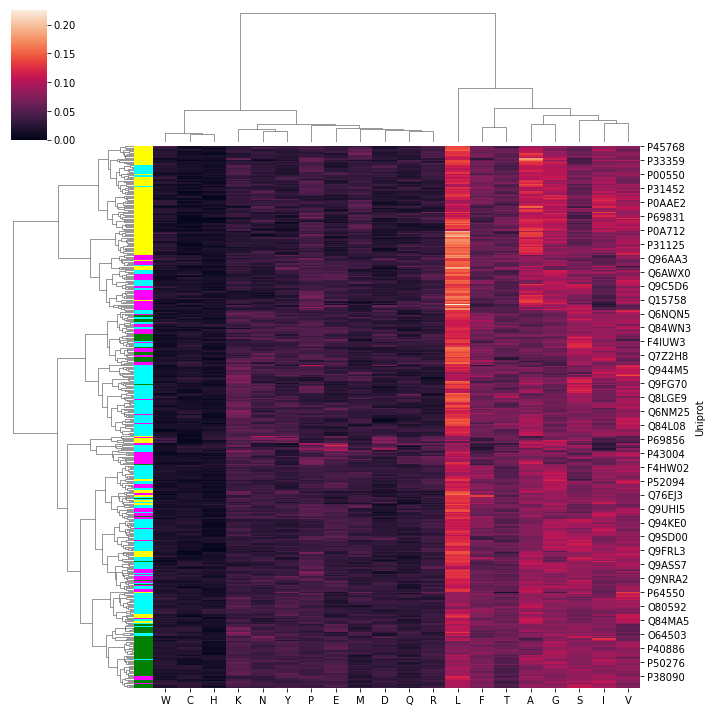

In [15]:
organism_ids = pd.DataFrame(df_aac.index).merge(
    df_annotation, how="left", on="Uniprot"
)[["Uniprot", "organism_id"]]
colormap = {
    x: y
    for x, y in zip([3702, 9606, 83333, 559292], ["cyan", "magenta", "yellow", "green"])
}
organism_ids = organism_ids.assign(
    color=organism_ids.organism_id.apply(lambda x: colormap[x])
)
organism_colors = organism_ids.color.tolist()
sns.clustermap(df_aac, method="ward", row_colors = organism_colors)
colormap

#### Pairwise correlations

When looking at the pairwise correlations, there is a low number of proteins with only a low corrleation to the rest of the dataset. These proteins make up the remaining outliers in human and a thaliana that were found in the individual notebooks. 

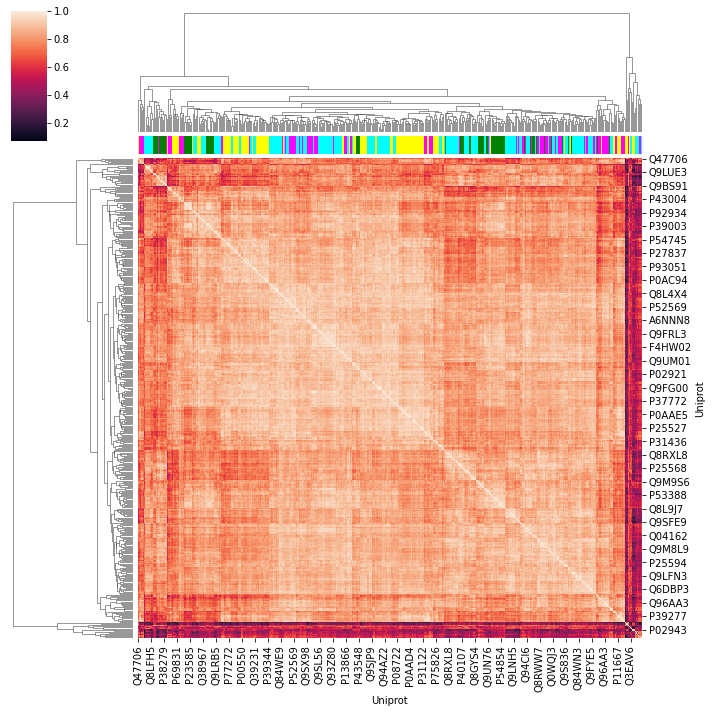

In [16]:
df_aac_corr = df_aac.T.corr()
sns.clustermap(df_aac_corr, col_colors=organism_colors)

In [17]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(linkage="ward", n_clusters=2)

agg.fit(df_aac_corr)

clustering = pd.DataFrame(df_aac_corr.index).assign(label = agg.labels_)

df_annotation[df_annotation.Uniprot.isin(clustering[clustering.label == 1].Uniprot.tolist())]

,Uniprot,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
103,P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
182,Q9HBR0,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A10 PP1744,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.16,9606,MTAAAASNWGLITNIVNSIVGVSVLTMPFCFKQCGIVLGALLLVFC...
188,Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...
272,P64550,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,alaE ygaW b2670 JW2645,L-alanine exporter AlaE,NaN,83333,MFSPQSRLRHAVADTFAMVVYCSVVNMCIEVFLSGMSFEQSFYSRL...
292,P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
306,P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
333,P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...
421,O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
422,Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
423,Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...


# Dataset

In [19]:
LOG_FILE = "../logs/meta_amino_sugar.log"
N_THREADS = 16
ORGANISM = "meta"

# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass
# e coli, a thaliana, human
create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=["P76773", "Q47706", "P64550", "P02943", "P75733", "P69856"]
    + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
    + ["Q9HBR0", "Q07837"],
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
...,...,...,...,...,...,...,...,...
Q04162,Sugar transport,Membrane;Transmembrane,Transport,YDR387C,Probable metabolite transport protein YDR387C,2.A.1.1.101,559292,MSTDESEDVYSDLYSIISQVTSNTANDIEQLPYALTFKTSLIFVGA...
P33361,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,yehY b2130 JW2118,Glycine betaine uptake system permease protein...,3.A.1.12.15,83333,MTYFRINPVLALLLLLTAIAAALPFISYAPNRLVSGEGRHLWQLWP...
P39328,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,ytfT b4230 JW5753,Galactofuranose transporter permease protein YtfT,3.A.1.2.25,83333,MMPQSLPDTTTPKRRFRWPTGMPQLVALLLVLLVDSLVAPHFWQVV...


In [20]:
df_annotation = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv")

In [21]:
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    index_col=0,
)

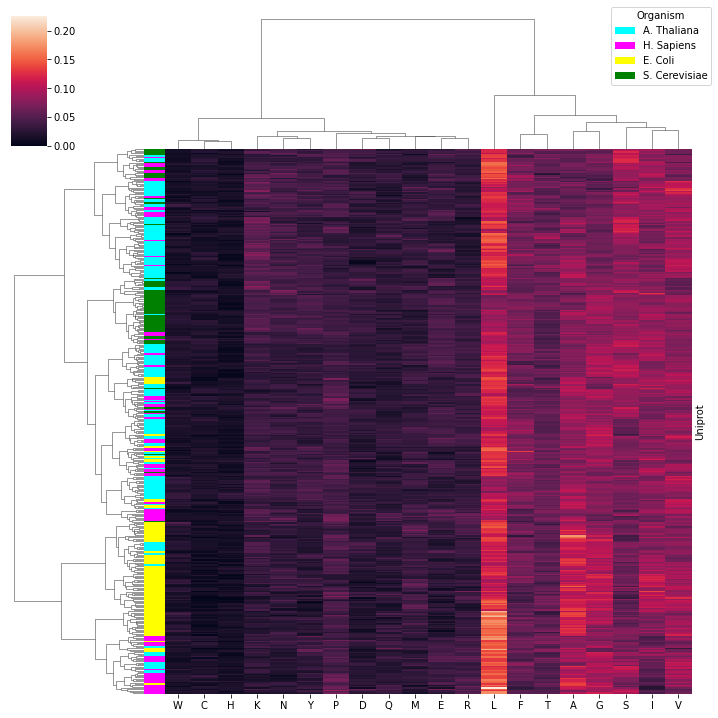

In [22]:
import matplotlib.pyplot as plt
organism_ids = pd.DataFrame(df_aac.index).merge(
    df_annotation, how="left", on="Uniprot"
)[["Uniprot", "organism_id"]]
colormap = {
    x: y
    for x, y in zip([3702, 9606, 83333, 559292], ["cyan", "magenta", "yellow", "green"])
}
organism_ids = organism_ids.assign(
    color=organism_ids.organism_id.apply(lambda x: colormap[x])
)
organism_colors = organism_ids.color.tolist()
sns.clustermap(df_aac, method="ward", row_colors=organism_colors, yticklabels=False)

from matplotlib.patches import Patch
colormap = dict(zip(["A. Thaliana", "H. Sapiens", "E. Coli", "S. Cerevisiae"], ["cyan", "magenta", "yellow", "green"]))

handles = [Patch(facecolor=colormap[name]) for name in colormap]
plt.legend(handles, colormap, title='Organism',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.savefig("meta_clustermap.png", dpi=300)

In [24]:
# df_aaindex = pd.read_csv("aaindex.csv")
# col1 = pd.Series(
#     data=df_aaindex.loc[0].tolist(),
#     index=df_aaindex.columns.to_series().apply(lambda x: x[0]).tolist(),
# )
# col2 = pd.Series(
#     data=df_aaindex.loc[0].tolist(),
#     index=df_aaindex.columns.to_series().apply(lambda x: x[2]).tolist(),
# )
# aaindex = pd.concat([col1,col2]).sort_index()

# from sklearn.feature_selection import SelectFromModel
# from sklearn.preprocessing import minmax_scale
# kbest = SelectKBest(k=20)
# fmodel = SelectFromModel(LinearSVC(class_weight="balanced"))
# df_aac
# labels = df_annotation.set_index("Uniprot").keywords_transport
# print(labels.value_counts())
# labels = np.where(labels == "Amino-acid transport", 0, 1)

# kbest.fit(df_aac, labels)


# kbest = pd.Series(index = kbest.feature_names_in_, data=kbest.scores_).sort_index()
# df = pd.DataFrame(kbest, columns=["kbest"]).assign(aaindex=aaindex)

# # df.kbest = minmax_scale(df.kbest)
# df.kbest = df.kbest.apply(lambda x: x / df.kbest.sum())
# # df.aaindex = minmax_scale(df.aaindex)
# df.aaindex = df.aaindex.apply(lambda x: x / df.aaindex.sum())
# df = df.sort_values("aaindex", ascending=False)
# print(df.corr())


# # df
# # sns.histplot(data=df.reset_index().melt(id_vars=["index"]), x="index", weights="value", hue="variable", multiple="stack")

# sns.barplot(
#     data=df.reset_index().melt(id_vars=["index"]), x="index", y="value", hue="variable"
# )



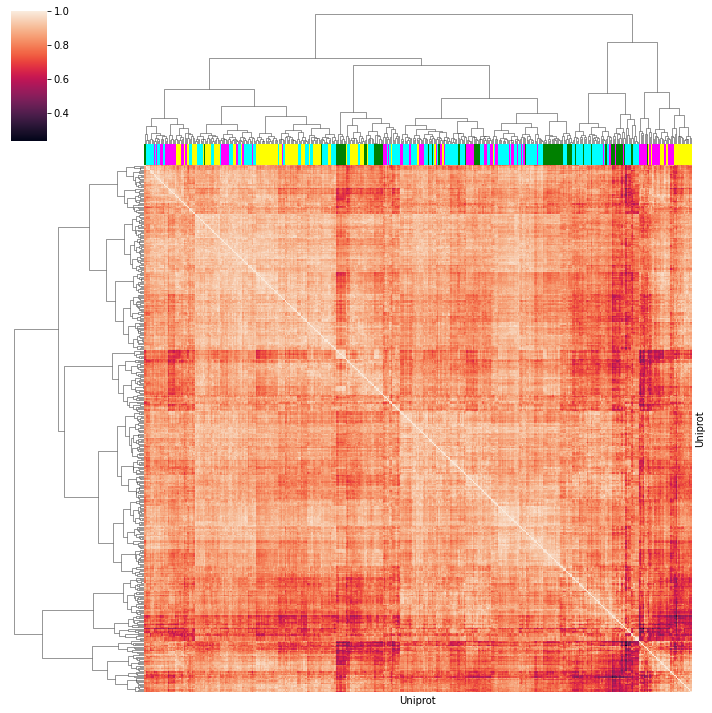

In [25]:
sns.clustermap(
    df_aac.T.corr(),
    method="ward",
    col_colors=organism_colors,
    yticklabels=False,
    xticklabels=False,
)